In [1]:
import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from itertools import chain  
from wordcloud import WordCloud

# Importing Raw data

In [2]:
df = pd.read_csv("combined_data_for_FIRE_reddits.csv")

# Basic Data Exploration 

In [3]:
# Calculate the number of unique posts
unique_post_counts = df['post_title'].nunique()

# Calculate the total number of comments
total_comments = len(df)

# Calculate the average number of comments per post
average_comments_per_post = round(total_comments / unique_post_counts)

print("Number of Posts:", unique_post_counts)
print("Total Number of Comments:", total_comments)
print("Average Number of Comments per Post:", average_comments_per_post)

Number of Posts: 734
Total Number of Comments: 38015
Average Number of Comments per Post: 52


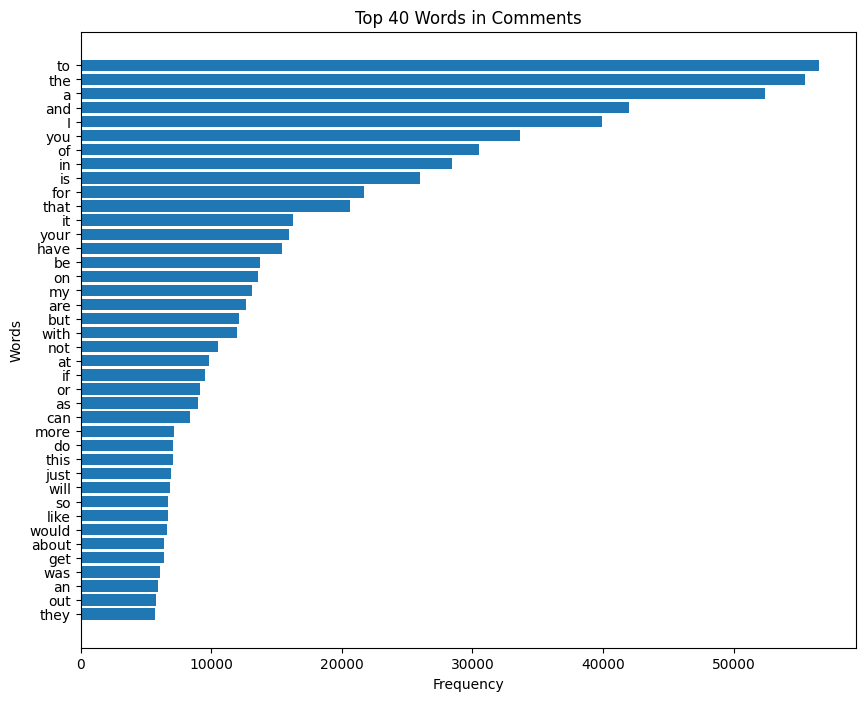

In [4]:
text_corpus = ' '.join(df['comment'])

# Tokenize the text (split into words)
words = text_corpus.split()

# Count the frequency of each word
word_counts = Counter(words)

# Sort the words by frequency in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 40 words
top_40_words = sorted_word_counts[:40]

# Extract words and counts for the bar graph
top_words, top_counts = zip(*top_40_words)

# Create a bar graph
plt.figure(figsize=(10, 8))
plt.barh(top_words, top_counts)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Words in Comments')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words at the top
plt.show()


# Data Cleaning 

Check and remove duplicates if any

In [5]:
duplicate_rows = df[df.duplicated()]
print("Number of Duplicate Rows:")
print(duplicate_rows.shape[0])

Number of Duplicate Rows:
97


In [6]:
df= df.drop_duplicates()

In [7]:
# Making a copy of comment column for further cleaning
df['processed_comment'] = df['comment']

Removing unwanted characters

In [8]:
# Function to check for Unicode characters
def has_unicode(text):
    if isinstance(text, str):
        return any(ord(char) >= 128 for char in text)
    return False

# Function to check for hyperlinks
def has_hyperlinks(text):
    if isinstance(text, str):
        return bool(re.search(r'http[s]?://\S+', text))
    return False

# Function to check for Username tags/mentions
def has_mentions(text):
    if isinstance(text, str):
        return bool(re.search(r'\/?[ur]\/[a-zA-Z0-9_-]+', text))
    return False

# Function to check for digits and numbers
def has_digits_and_numbers(text):
    if isinstance(text, str):
        return bool(re.search(r'\d+', text))
    return False

# Create boolean masks to identify rows with Unicode characters, hyperlinks, and username mentions
unicode_mask = df['processed_comment'].apply(has_unicode) 
hyperlinks_mask = df['processed_comment'].apply(has_hyperlinks) 
mentions_mask = df['processed_comment'].apply(has_mentions) 
digits_and_numbers_mask = df['processed_comment'].apply(has_digits_and_numbers)

# Display no. of rows with Unicode characters
print("Rows with Unicode characters:")
print(df[unicode_mask].shape[0])

# Display no. of rows with hyperlinks
print("\nRows with hyperlinks:")
print(df[hyperlinks_mask].shape[0])

# Display no. of rows with user mentions
print("\nRows with user mentions or subreddit names:")
print(df[mentions_mask].shape[0])

# Display no. of rows with digits and numbers
print("\nRows with digits and numbers:")
print(df[digits_and_numbers_mask].shape[0])

Rows with Unicode characters:
9723

Rows with hyperlinks:
994

Rows with user mentions or subreddit names:
690

Rows with digits and numbers:
17786


In [9]:
def clean_data(df):
    preserved_unicode = ['\u2018','\u2019', '\u2026', '\u2022', '\u201C', '\u201D'] 
    def remove_unicode(text):
        if isinstance(text, str):
            cleaned_text = ''.join([c for c in text if ord(c) < 128 or c in preserved_unicode])
            return cleaned_text
        return text
    
    def remove_hyperlinks(text):
        if isinstance(text, str):
            return re.sub(r'http[s]?://\S+', '', text)
        return text
    
    def remove_user_mentions(text):
        if isinstance(text, str):
            return re.sub(r'\/?[ur]\/[a-zA-Z0-9_-]+', '', text)
        return text

    df_cleaned = df.copy()
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_unicode)
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_hyperlinks)
    df_cleaned['processed_comment'] = df_cleaned['processed_comment'].apply(remove_user_mentions)
    return df_cleaned

cleaned_df = clean_data(df)

In [10]:
# Define a list of common contractions
contractions = {
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "i've": "i have",
    "you've": "you have",
    "he's": "he has",
    "she's": "she has",
    "we've": "we have",
    "they've": "they have",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "we'll": "we will",
    "they'll": "they will",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "we'd": "we would",
    "they'd": "they would",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "that's":"that is ",
    "what's":"what is",
    "would've":"would have",
    "gfy":"good for you"
}

# Define a function to preprocess comments
def preprocess_comments(comment):
    # Decode HTML entities to handle Unicode characters
    comment = unidecode(comment)

    # Preserve contractions
    for contraction, expanded_form in contractions.items():
        comment = re.sub(rf'\b{contraction}\b', expanded_form, comment, flags=re.IGNORECASE)

    # Remove special characters and numbers
    comment = re.sub(r'[^A-Za-z\s]', '', comment)

    return comment

# Create a new column to store the processed comments
cleaned_df['processed_comment'] = cleaned_df['processed_comment'].apply(preprocess_comments)


Removing Empty Rows

In [11]:
# Remove rows where the 'comments' column is empty or consists of whitespace
cleaned_df = cleaned_df[cleaned_df['processed_comment'].str.strip().astype(bool)]

Case folding 

In [12]:
cleaned_df['processed_comment'] = cleaned_df['processed_comment'].str.lower()

Tokenization

In [13]:
# Tokenize the specified column and create a new column for tokens
cleaned_df['tokens'] = cleaned_df['processed_comment'].apply(lambda x: word_tokenize(x))

Removing Stopwords

In [14]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a dictionary to store stop word and single character word counts
stopword_counts = {}

# Function to remove stopwords, single character words, and count them
def remove_stopwords_and_single_chars(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # Count stop words and single character words and store their frequencies
    for word in tokens:
        if word in stop_words or len(word) == 1:
            if word in stopword_counts:
                stopword_counts[word] += 1
            else:
                stopword_counts[word] = 1
    
    return filtered_tokens

cleaned_df['filtered_tokens'] = cleaned_df['tokens'].apply(remove_stopwords_and_single_chars)

# Print the stop word and single character word counts
print("Stop Word and Single Character Word Counts:")
for word, count in stopword_counts.items():
    print(f"{word}: {count}")

Stop Word and Single Character Word Counts:
for: 23105
you: 46502
and: 44237
yourself: 998
off: 3235
to: 57382
be: 14198
in: 30462
i: 53273
your: 16744
is: 40088
of: 30886
am: 8714
not: 29664
the: 60413
that: 27034
she: 1797
does: 3006
at: 10708
what: 7409
down: 2276
a: 53572
few: 1761
will: 10934
from: 5786
k: 11020
when: 5006
did: 2868
about: 6697
some: 4722
are: 19759
do: 15512
with: 12753
all: 5516
now: 4460
s: 1406
or: 10059
before: 1736
it: 30903
any: 2620
my: 15294
but: 14906
until: 1415
was: 6627
no: 4544
so: 9375
which: 2941
on: 14243
out: 6703
then: 4409
have: 19668
above: 474
up: 5371
over: 2806
how: 4368
where: 2339
can: 10643
here: 1961
if: 14982
into: 3804
our: 2700
just: 7944
more: 7989
than: 4964
most: 2756
only: 3376
as: 9831
these: 1257
an: 6039
after: 2263
because: 3499
there: 4603
they: 7981
between: 777
once: 1086
being: 2284
having: 1538
same: 2092
had: 2786
too: 2008
by: 3400
this: 10278
has: 3870
me: 4867
while: 1800
doing: 1946
them: 3021
under: 529
his: 1149
h

Lemmatization

In [15]:
# Load lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=nltk.corpus.wordnet.VERB) for token in tokens]
    return lemmatized_tokens

cleaned_df['lemmatized_tokens'] = cleaned_df['filtered_tokens'] .apply(lemmatize_tokens)

Sanity Check

In [16]:
# Function to check for Unicode characters
def has_unicode(text):
    if isinstance(text, str):
        return any(ord(char) >= 128 for char in text)
    return False

# Function to check for hyperlinks using regex
def has_hyperlinks(text):
    if isinstance(text, str):
        return bool(re.search(r'http[s]?://\S+', text))
    return False

# Function to check for Username tags/mentions
def has_mentions(text):
    if isinstance(text, str):
        return bool(re.search(r'\/?[ur]\/[a-zA-Z0-9_-]+', text))
    return False

# Function to check for digits and numbers
def has_digits_and_numbers(text):
    if isinstance(text, str):
        return bool(re.search(r'\d+', text))
    return False

# Create boolean masks to identify rows with Unicode characters, hyperlinks, and username mentions
unicode_mask = cleaned_df['processed_comment'].apply(has_unicode)
hyperlinks_mask = cleaned_df['processed_comment'].apply(has_hyperlinks)
mentions_mask = cleaned_df['processed_comment'].apply(has_mentions)
digits_and_numbers_mask = cleaned_df['processed_comment'].apply(has_digits_and_numbers)

# Display no. of rows with Unicode characters
print("Rows with Unicode characters:")
print(cleaned_df[unicode_mask].shape[0])

# Display no. of rows with hyperlinks
print("\nRows with hyperlinks:")
print(cleaned_df[hyperlinks_mask].shape[0])

# Display no. of rows with user mentions
print("\nRows with user mentions or subreddit names:")
print(cleaned_df[mentions_mask].shape[0])

# Display no. of rows with digits and numbers
print("\nRows with digits and numbers:")
print(cleaned_df[digits_and_numbers_mask].shape[0])

Rows with Unicode characters:
0

Rows with hyperlinks:
0

Rows with user mentions or subreddit names:
0

Rows with digits and numbers:
0


In [17]:
# Flatten the list of tokens into a single list of words
all_words = [word for tokens in cleaned_df['lemmatized_tokens'] for word in tokens]

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 words
top_20_words = word_counts.most_common(20)

# Print the top 10 words and their frequencies
for word, frequency in top_20_words:
    print(f"{word}: {frequency}")

would: 10772
get: 10675
work: 8257
make: 7822
go: 7523
like: 7469
years: 7419
money: 6311
pay: 6110
time: 5977
year: 5743
think: 5512
want: 5446
people: 5298
need: 5008
save: 4844
take: 4590
tax: 4514
much: 4452
live: 4206


In [18]:
cleaned_df['lemmatized_tokens'] = cleaned_df['lemmatized_tokens'].apply(lambda tokens: ['rate' if word == 'rates' or word == 'rat' else word for word in tokens])
cleaned_df['lemmatized_tokens'] = cleaned_df['lemmatized_tokens'].apply(lambda tokens: ['year' if word == 'years' else word for word in tokens])

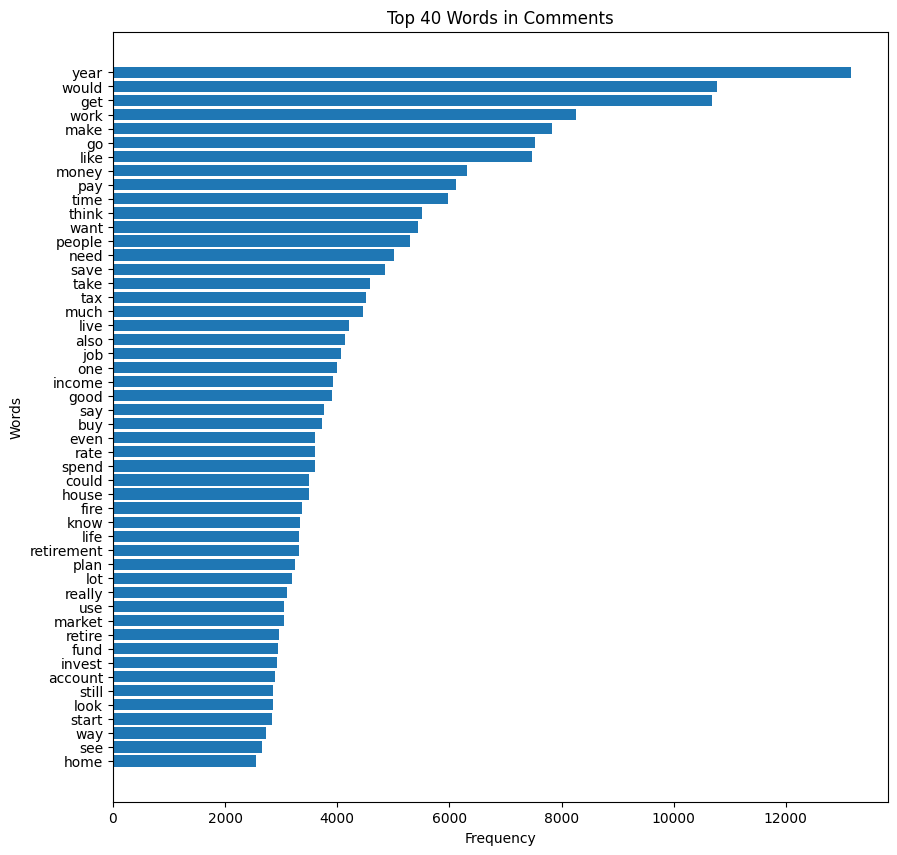

In [19]:
# Flatten the list of lists into a single list
all_tokens = list(chain.from_iterable(cleaned_df['lemmatized_tokens']))

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Sort the tokens by frequency in descending order
sorted_token_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 40 tokens
top_50_tokens = sorted_token_counts[:50]

# Extract tokens and counts for the bar graph
top_tokens, top_counts = zip(*top_50_tokens)

# Create a bar graph
plt.figure(figsize=(10, 10))
plt.barh(top_tokens, top_counts)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Words in Comments')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent tokens at the top
plt.show()


Total Word Count before cleaning the dataset:  1953798
Total Word Count after cleaning the dataset: : 936470


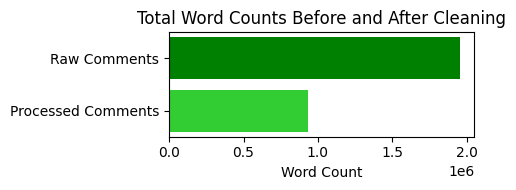

In [20]:
word_count_raw_comments = cleaned_df['comment'].apply(lambda x: len(x.split())).sum()
word_count_processed_comments = cleaned_df['lemmatized_tokens'].apply(lambda x: len(x)).sum()
print("Total Word Count before cleaning the dataset: ", word_count_raw_comments)
print("Total Word Count after cleaning the dataset: :", word_count_processed_comments)

# Create a horizontal bar graph to compare word counts
plt.figure(figsize=(5, 2))
plt.barh(['Raw Comments', 'Processed Comments'], [word_count_raw_comments, word_count_processed_comments], color=['green', 'limegreen'])
plt.xlabel('Word Count')
plt.title('Total Word Counts Before and After Cleaning')
plt.gca().invert_yaxis()  # Invert y-axis to display Raw Comments at the top
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
cleaned_df.to_csv("FIRE_cleaned_data.csv", index=False)

In [22]:
cleaned_df.to_json('FIRE_cleaned_data.json', orient='records', lines=True)